In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings(action='ignore')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
international = pd.read_csv('international_trade.csv')

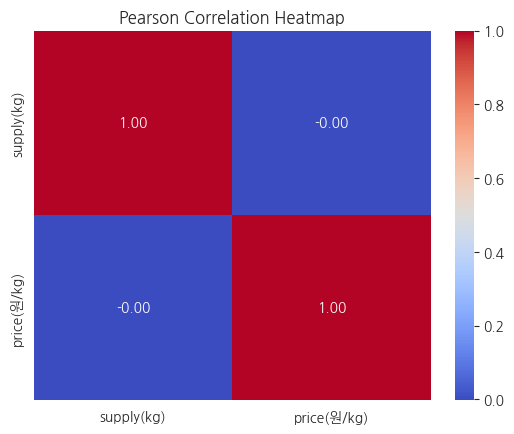

In [3]:
numerical_cols = train.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_cols.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Pearson Correlation Heatmap')
plt.show()

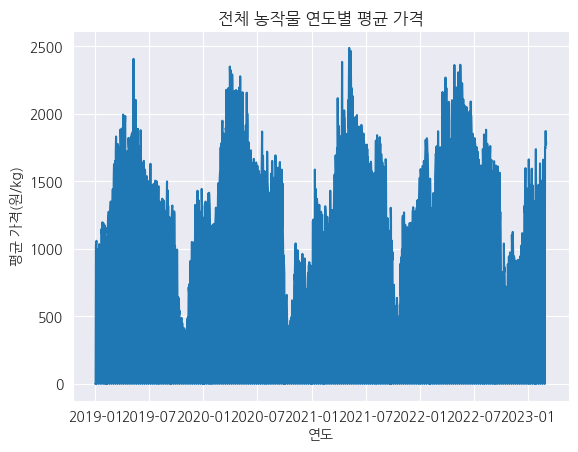

In [5]:
# timestamp 컬럼을 datetime 형식으로 변환
train['timestamp'] = pd.to_datetime(train['timestamp'])

# 연도별 평균 가격 계산
year_price = train.groupby('timestamp').agg({'price(원/kg)':'mean'})

# 그래프 출력
plt.plot(year_price.index, year_price['price(원/kg)'])
plt.xlabel('연도')
plt.ylabel('평균 가격(원/kg)')
plt.title('전체 농작물 연도별 평균 가격')
plt.show()

In [10]:
def pre_all(train, test):
    print(f"전처리 전 train 크기 : {train.shape}")
    print(f"전처리 전 test 크기 : {test.shape}")
    print("=================전처리 중=================")

    # 합쳐서 전처리하기
    train["timestamp"] = pd.to_datetime(train["timestamp"])
    test["timestamp"] = pd.to_datetime(test["timestamp"])
    df = pd.concat([train,test]).reset_index(drop = True)

    df.rename(columns={'supply(kg)':'supply', 'price(원/kg)':'price'},inplace=True)

    #년/월/일 추가
    df['year']=df['timestamp'].dt.year
    df['month']=df['timestamp'].dt.month
    df['day']=df['timestamp'].dt.day

    #요일 추가
    df['week_day']=df['timestamp'].dt.weekday

    # 년-월 변수 추가 : year-month의 형태, 개월단위 누적값
    le = LabelEncoder()
    df["year_month"] = df["timestamp"].map(lambda x :str(x.year) + "-"+str(x.month))

    # 라벨 인코딩
    df["year_month"] = le.fit_transform(df["year_month"])


    # 주차 변수 추가
    df["week"] = df["timestamp"].map(lambda x: datetime.datetime(x.year, x.month, x.day).isocalendar()[1])

    # 주차 누적값
    week_list=[]
    for i in range(len(df['year'])) :
        if df['year'][i] == 2019 :
            week_list.append(int(df['week'][i]))
        elif df['year'][i] == 2020 :
            week_list.append(int(df['week'][i])+52)
        elif df['year'][i] == 2021 :
            week_list.append(int(df['week'][i])+52+53)
        elif df['year'][i] == 2022 :
            week_list.append(int(df['week'][i])+52+53+53)
        elif df['year'][i] == 2023 :
            week_list.append(int(df['week'][i])+52+53+53+52)
    df['week_num']= week_list

    # datetime 패키지에서 19년 12월 마지막주가 첫째주로 들어가는거 발견하여 수정
    df.loc[df['timestamp']=='2019-12-30','week_num']=52
    df.loc[df['timestamp']=='2019-12-31','week_num']=52


    # 공휴일 변수 추가
    def make_holi(x):
        kr_holi = holidays.KR()

        if x in kr_holi:
            return 1
        else:
            return 0

    df["holiday"] = df["timestamp"].map(lambda x : make_holi(x))


    # train, test 분리하기
    train = df[~df["price"].isnull()].sort_values("timestamp").reset_index(drop = True)
    test = df[df["price"].isnull()].sort_values("timestamp").reset_index(drop=True)


    print(f"전처리 후 train 크기 : {train.shape}")
    print(f"전처리 후 test 크기 : {test.shape}")

    return train, test

In [13]:
import pandas as pd
import numpy as np
import datetime
import random
import os
import sys
import holidays


import sklearn
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [14]:
train_pre, test_pre = pre_all(train, test)

전처리 전 train 크기 : (59397, 7)
전처리 전 test 크기 : (1092, 5)
=================전처리 중=================
전처리 후 train 크기 : (59397, 15)
전처리 후 test 크기 : (1092, 15)


In [15]:
train_pre

,ID,timestamp,item,corporation,location,supply,price,year,month,day,week_day,year_month,week,week_num,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,0,1,1,1
1,CB_A_S_20190101,2019-01-01,CB,A,S,0.0,0.0,2019,1,1,1,0,1,1,1
2,RD_D_J_20190101,2019-01-01,RD,D,J,0.0,0.0,2019,1,1,1,0,1,1,1
3,BC_D_J_20190101,2019-01-01,BC,D,J,0.0,0.0,2019,1,1,1,0,1,1,1
4,CB_F_J_20190101,2019-01-01,CB,F,J,0.0,0.0,2019,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,CR_E_S_20230303,2023-03-03,CR,E,S,0.0,0.0,2023,3,3,4,50,9,219,0
59393,BC_A_S_20230303,2023-03-03,BC,A,S,3776.0,2875.0,2023,3,3,4,50,9,219,0
59394,CB_E_J_20230303,2023-03-03,CB,E,J,0.0,0.0,2023,3,3,4,50,9,219,0
59395,BC_D_J_20230303,2023-03-03,BC,D,J,1776.0,3059.0,2023,3,3,4,50,9,219,0


In [23]:
train_pre

,ID,timestamp,item,corporation,location,supply,price,year,month,day,week_day,year_month,week,week_num,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,0,1,1,1
1,CB_A_S_20190101,2019-01-01,CB,A,S,0.0,0.0,2019,1,1,1,0,1,1,1
2,RD_D_J_20190101,2019-01-01,RD,D,J,0.0,0.0,2019,1,1,1,0,1,1,1
3,BC_D_J_20190101,2019-01-01,BC,D,J,0.0,0.0,2019,1,1,1,0,1,1,1
4,CB_F_J_20190101,2019-01-01,CB,F,J,0.0,0.0,2019,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,CR_E_S_20230303,2023-03-03,CR,E,S,0.0,0.0,2023,3,3,4,50,9,219,0
59393,BC_A_S_20230303,2023-03-03,BC,A,S,3776.0,2875.0,2023,3,3,4,50,9,219,0
59394,CB_E_J_20230303,2023-03-03,CB,E,J,0.0,0.0,2023,3,3,4,50,9,219,0
59395,BC_D_J_20230303,2023-03-03,BC,D,J,1776.0,3059.0,2023,3,3,4,50,9,219,0


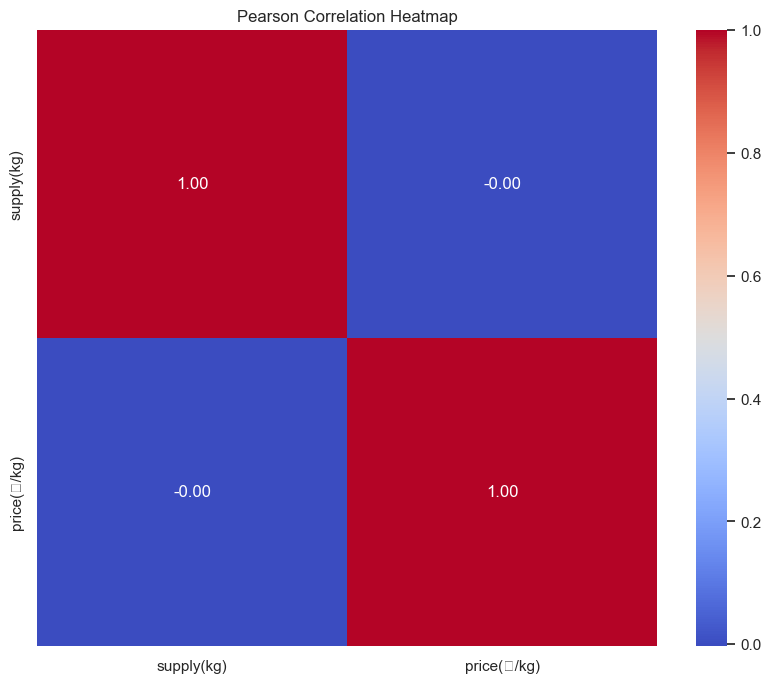

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns

# 1. 데이터 준비

# 데이터 불러오기
train_pre = pd.read_csv('train.csv')

# 숫자형 데이터 선택
numerical_cols = train_pre.select_dtypes(include=['int64', 'float64'])

# 2. 상관계수 계산

# 상관계수 계산 방법 선택
corr_matrix = numerical_cols.corr(method='pearson')  # 피어슨 상관계수

# NaN 값 처리
corr_matrix = corr_matrix.dropna()  # NaN 값 제거

# 3. 그래프 그리기

# 히트맵 설정
sns.set(style="white")

# 상관계수 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')

# 그래프 제목 설정
plt.title('Pearson Correlation Heatmap')

# 그래프 출력
plt.show()

findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.
findfont: Font family '나눔고딕' not found.


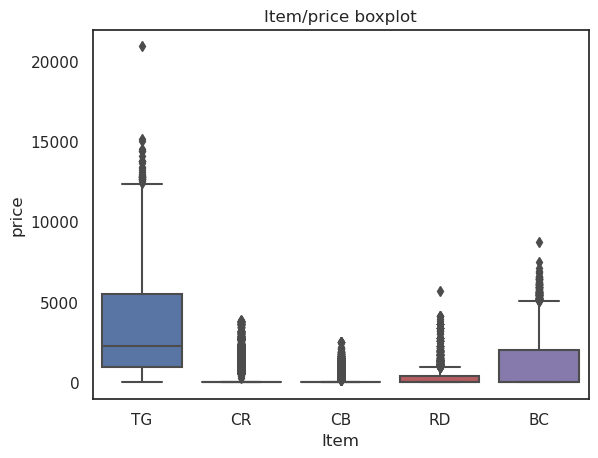

In [36]:
import seaborn as sns
import pandas as pd

# 데이터 불러오기
df = train_pre

# 가로축: item, 세로축: price(원/kg)으로 박스플롯 그래프 생성
sns.boxplot(x='item', y='price(원/kg)', data=df)

# 그래프 제목 설정
plt.title('Item/price boxplot')

# x축 레이블 설정
plt.xlabel('Item')

# y축 레이블 설정
plt.ylabel('price')

# 그래프 표시
plt.show()


In [37]:
## 전처리

# 극 이상치 제거
tg_idx = train_pre[(train_pre["item"]=="TG") & (train_pre["price"]>20000)].index
rd_idx = train_pre[(train_pre["item"]=="RD") & (train_pre["price"]>5000)].index
bc_idx = train_pre[(train_pre["item"]=="BC") & (train_pre["price"]>8000)].index
cb_idx = train_pre[(train_pre["item"]=="CB") & (train_pre["price"]>2300)].index

train_pre.loc[tg_idx,"price"] = train_pre[(train_pre["item"]=="TG") & (train_pre["price"]!=0)]["price"].mean()
train_pre.loc[rd_idx,"price"] = train_pre[(train_pre["item"]=="RD") & (train_pre["price"]!=0)]["price"].mean()
train_pre.loc[bc_idx,"price"] = train_pre[(train_pre["item"]=="BC") & (train_pre["price"]!=0)]["price"].mean()
train_pre.loc[cb_idx,"price"] = train_pre[(train_pre["item"]=="CB") & (train_pre["price"]!=0)]["price"].mean()


# 감귤이 아닌것
print(f"train의 컬럼 : {train_pre.columns}")
print(f"test의 컬럼 : {test_pre.columns}")

train_notg = train_pre[train_pre["item"] !="TG"]
test_notg = test_pre[test_pre["item"] != "TG"]


#인코딩
Xy = pd.get_dummies(train_notg.sort_values(by = ["timestamp"]).reset_index(drop=True).drop(columns = ["supply"]), columns = ["item","corporation","location"])
answer_notg = pd.get_dummies(test_notg.drop(columns = ["timestamp","supply","price"]), columns = [ "item","corporation","location"])
print(Xy.columns)

KeyError: 'price'